In [1]:
from _tests import scripts
from scripts.notebook_utils import *


In [15]:
def run_layer(dnn: str, layer: str):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "cascade",
        # Weight-stationary, dummy buffer on top to hold inputs & outputs, many
        # macros to ensure we can fit all weights.
        system="cascade_dummy_buffer_many_macro",
        # Set the DNN and layer
        dnn=dnn,
        layer=layer,
    )
    

    # Do NOT generate a maximum-utilization workload; we're running a DNN
    # workload.
    spec.variables["MAX_UTILIZATION"] = False

    # spec.architecture.find("column").spatial.meshX = 64
    # spec.architecture.find("row").spatial.meshY = 64
    # spec.architecture.find("buffer_rram").attributes.depth = 32
    # spec.architecture.find("buffer_rram").attributes.width = 32
    # display_diagram(spec.to_diagram(["macro", "cim_array", "column", "row"]))
    # factors = spec.architecture.find("adc").constraints.temporal.factors_only
    # factors.add_eq_factor("X", 8, overwrite=True)
    # factors_2 = spec.architecture.find("row_drivers").constraints.temporal.factors_only
    # factors_2.add_eq_factor("X", 16, overwrite=True)

    
    return run_mapper(spec)


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../../../workloads/")
    if os.path.isdir(f"../../../workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "vgg16"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers_2 = [f for f in os.listdir(f"../../../workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers_2 = sorted(layers_2)
real_layers_2 = layers_2
print(f"Running: ", end="")

results_2 = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0]) for layer in real_layers_2
)
print("")

Available DNNs: ['gpt2_medium', 'vgg16', 'mobilenet_v3', 'msft_phi_1_5', 'alexnet', 'mobilebert', 'vision_transformer', 'densenet201', 'resnet18', 'dpt_large']
Running: 00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 


total energy 0.0011576736105373057
43200000000.0
153600000000.0
153600000000.0
153600000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
204800000000.0
256000000000.0
avg throughput 188.3
{'cim_unit': 2.0807680000000003e-16, 'row_drivers': 5.9392e-14, 'cascade_tia': 2.7361279999999997e-15, 'sum_amp': 1.5605760000000001e-15, 'adc': 8.72448e-15}
{'CiM': 6.29576704e-14, 'Accumulation': 3.3321702400000002e-15, 'ADC': 1.8645145600000004e-14}
{'CiM': 74.12454300292825, 'Accumulation': 3.9232010123417433, 'ADC': 21.952255984730005}


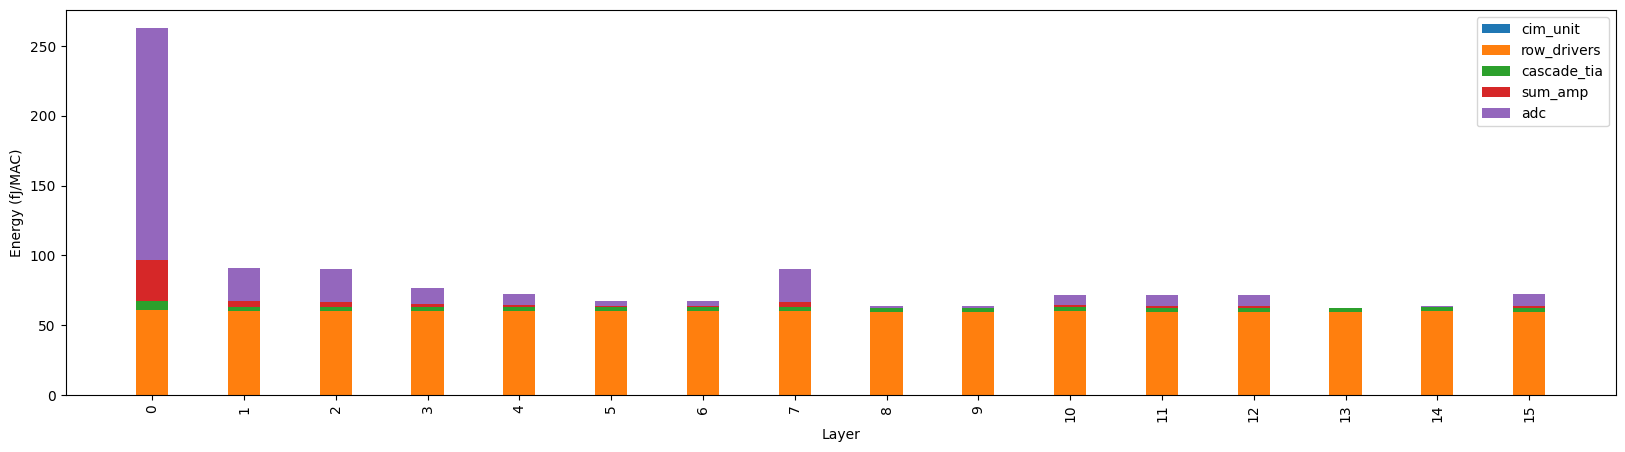

In [17]:
import copy

results_copy = copy.deepcopy(results_2)
total_energy = 0
for r in results_copy:
    total_energy += r.energy

print("total energy", total_energy)

per_computer_dict = {}
total_throughput = 0
num_layers = 0
for r in results_copy:
    # print(r)
    r.clear_zero_energies()
    num_layers += 1
    per_compute_dict = r.per_compute("per_component_energy")
    total_throughput += r.computes_per_second
    print(r.computes_per_second)
avg_throughput = total_throughput/num_layers
print("avg throughput", avg_throughput/1e9)
print(per_compute_dict)


total_per_compute = {'CiM': 0, 'Accumulation': 0, 'ADC': 0}
for r in results_copy:
    per_compute = r.per_compute("per_component_energy")
    total_per_compute['CiM'] += per_compute['cim_unit']
    total_per_compute['CiM'] += per_compute['row_drivers']
    total_per_compute['CiM'] += per_compute['cascade_tia']
    total_per_compute['Accumulation'] += per_compute['sum_amp']
    total_per_compute['ADC'] += per_compute['adc']

for k in total_per_compute:
    total_per_compute[k] = total_per_compute[k]/num_layers

print(total_per_compute)

percent_breakdown = {}
total_compute = 0
for k in total_per_compute:
    total_compute += total_per_compute[k]
percent_breakdown['CiM'] = (total_per_compute["CiM"]/total_compute) * 100
percent_breakdown['Accumulation'] = (total_per_compute["Accumulation"]/total_compute) * 100
percent_breakdown['ADC'] = (total_per_compute["ADC"]/total_compute) * 100
print(percent_breakdown)

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results_copy)},
    title="",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)

In [18]:
def run_layer(dnn: str, layer: str):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "cascade",
        system="cascade_dummy_buffer_many_macro",
        dnn=dnn,
        layer=layer,
    )
    
    spec.variables["MAX_UTILIZATION"] = False

    spec.architecture.find("macro_in_system").spatial.meshX = 40
    
    spec.variables["WEIGHT_BITS"] = 8
    spec.variables["INPUT_BITS"] = 8
    spec.variables["OUTPUT_BITS"] = 8

    spec.variables["ENCODED_OUTPUT_BITS"] = 8
    spec.variables["ADC_RESOLUTION"] = 5
    spec.variables["VOLTAGE_DAC_RESOLUTION"] = 8

    spec.variables["N_ADC_PER_BANK"] = 4
    
    # spec.architecture.find("column_drivers_2").width = 8
    # spec.architecture.find("buffer_rram").width = 8
    spec.architecture.find("column_drivers_2").width = 16
    spec.architecture.find("buffer_rram").width = 16
    spec.architecture.find("buffer_rram").depth = 32
    # spec.architecture.find("cascade_tia").width = 8
    spec.architecture.find("cascade_tia").width = 16

    # spec.architecture.find("column_drivers").width = 8
    spec.architecture.find("column_drivers").width = 16
    spec.architecture.find("column").spatial.meshX = 32
    spec.architecture.find("row").spatial.meshY = 32
    
    return run_mapper(spec)


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../../../workloads/")
    if os.path.isdir(f"../../../workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "mobilenet_v3"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers_2 = [f for f in os.listdir(f"../../../workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers_2 = sorted(layers_2)
print(len(layers_2))
real_layers_2 = layers_2
print(f"Running: ", end="")

results_2 = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0]) for layer in real_layers_2
)
print("")

Available DNNs: ['gpt2_medium', 'vgg16', 'mobilenet_v3', 'msft_phi_1_5', 'alexnet', 'mobilebert', 'vision_transformer', 'densenet201', 'resnet18', 'dpt_large']
64
Running: 00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 


total energy 3.0954472796080155e-05
10800000000.0
3600000000.0
6400000000.0
25600000000.0
7200000000.0
38400000000.0
43200000000.0
8100000000.0
43200000000.0
43200000000.0
22500000000.0
43200000000.0
43200000000.0
72000000000.0
60000000000.0
25000000000.0
96000000000.0
96000000000.0
60000000000.0
60000000000.0
25000000000.0
96000000000.0
96000000000.0
60000000000.0
60000000000.0
9000000000.0
120000000000.0
66666650390.625
9000000000.0
57142822265.625
61333300781.25
5175000000.0
122666650390.625
61333300781.25
5175000000.0
122666650390.625
106666650390.625
9000000000.0
96000000000.0
120000000000.0
89600000000.0
78400000000.0
7200000000.0
67200000000.0
78400000000.0
89600000000.0
78400000000.0
20000000000.0
67200000000.0
78400000000.0
128000000000.0
128000000000.0
25000000000.0
128000000000.0
120000000000.0
128000000000.0
128000000000.0
25000000000.0
128000000000.0
120000000000.0
128000000000.0
128000000000.0
128000000000.0
128000000000.0
avg throughput 67.82540664672851
{'cim_unit': 9.6

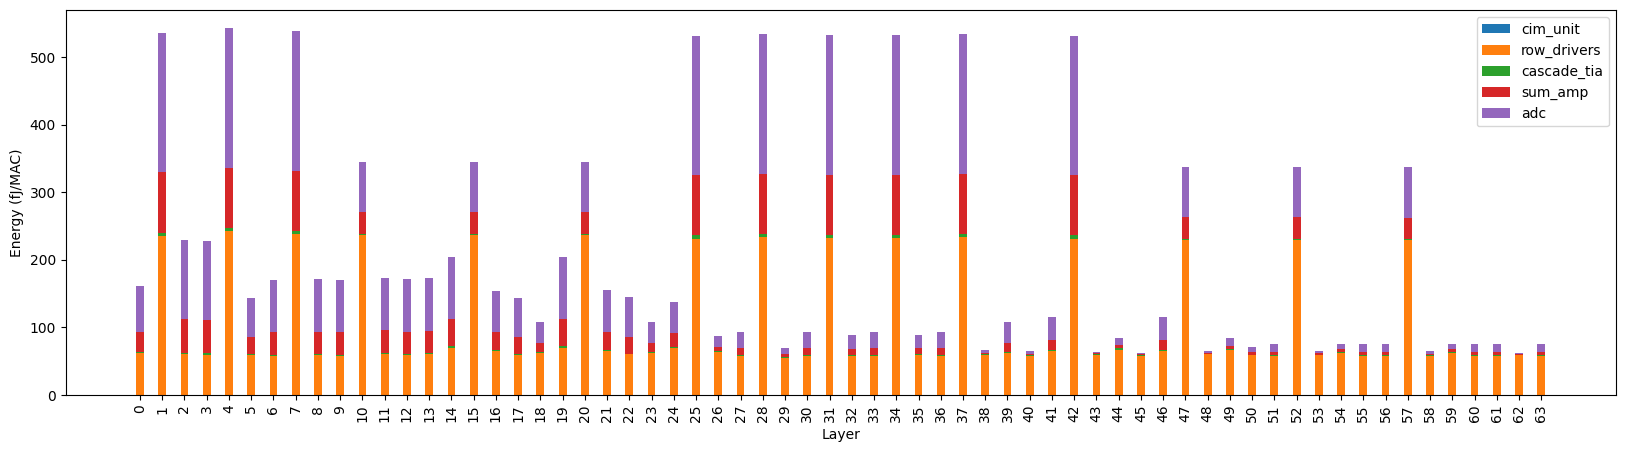

In [19]:
import copy

results_copy = copy.deepcopy(results_2)
total_energy = 0
for r in results_copy:
    total_energy += r.energy

print("total energy", total_energy)

per_computer_dict = {}
total_throughput = 0
num_layers = 0
for r in results_copy:
    # print(r)
    r.clear_zero_energies()
    num_layers += 1
    per_compute_dict = r.per_compute("per_component_energy")
    total_throughput += r.computes_per_second
    print(r.computes_per_second)
avg_throughput = total_throughput/num_layers
print("avg throughput", avg_throughput/1e9)
print(per_compute_dict)


total_per_compute = {'CiM': 0, 'Accumulation': 0, 'ADC': 0}
for r in results_copy:
    per_compute = r.per_compute("per_component_energy")
    total_per_compute['CiM'] += per_compute['cim_unit']
    total_per_compute['CiM'] += per_compute['row_drivers']
    total_per_compute['CiM'] += per_compute['cascade_tia']
    total_per_compute['Accumulation'] += per_compute['sum_amp']
    total_per_compute['ADC'] += per_compute['adc']

for k in total_per_compute:
    total_per_compute[k] = total_per_compute[k]/num_layers

print(total_per_compute)

percent_breakdown = {}
total_compute = 0
for k in total_per_compute:
    total_compute += total_per_compute[k]
percent_breakdown['CiM'] = (total_per_compute["CiM"]/total_compute) * 100
percent_breakdown['Accumulation'] = (total_per_compute["Accumulation"]/total_compute) * 100
percent_breakdown['ADC'] = (total_per_compute["ADC"]/total_compute) * 100
print(percent_breakdown)

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results_copy)},
    title="",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)